# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-r--r-- 1 root root 1.2K Feb  2 16:36 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
# TODO: Fix for faster protyping on a laptop. ratings_sample.csv contains 0.001 of the dataset.

# ratings_sample = ratings_df.sample(False, 0.001, seed=63)

# ratings_sample.count()

# ratings_sample.take(10)

# ratings_sample.printSchema()


# ratings_sample \
#     .write \
#     .format('com.databricks.spark.csv') \
#     .mode('overwrite') \
#     .csv(os.path.join(DATA_PATH, "ratings_sample.csv"), header=True, sep=',')

In [4]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings_sample.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [5]:
from pyspark.sql.types import *


# schema = StructType([
#     StructField('user_id', IntegerType()),
#     StructField('movie_id', IntegerType()),
#     StructField('rating', FloatType()),
#     StructField('timestamp', IntegerType())
# ])

schema = StructType([
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType()),
    StructField('user_id', IntegerType()),
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [6]:
ratings_df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- user_id: integer (nullable = true)



In [7]:
ratings_df.take(5)

[Row(movie_id=1373, rating=3.0, timestamp=979972198, user_id=65346),
 Row(movie_id=2640, rating=4.0, timestamp=979972646, user_id=65346),
 Row(movie_id=2822, rating=2.5, timestamp=1101236534, user_id=65365),
 Row(movie_id=82461, rating=3.0, timestamp=1386723589, user_id=65365),
 Row(movie_id=2065, rating=4.0, timestamp=939500148, user_id=65376)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [8]:
# ratings = sc.textFile('file:///' + RATINGS_PATH)

In [9]:
# ratings.take(5)

In [10]:
# from pyspark.sql import Row


# ratings_df = ratings \
#     .map(lambda s: s.split(',')) \
#     .filter(lambda arr: arr[0].isdigit()) \
#     .map(lambda arr: Row(movie_id=int(arr[0]), 
#                          rating=float(arr[1]), 
#                          timestamp=int(arr[2]),
#                          user_id=int(arr[3])))\
#     .toDF()

In [11]:
# ratings_df.printSchema()

---
## DataFrame API

In [12]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [13]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [14]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=304, mean_rating=5.0, ratings_count=1, movieId=304, title='Roommates (1995)', genres='Comedy|Drama'),
 Row(movie_id=394, mean_rating=5.0, ratings_count=1, movieId=394, title='Coldblooded (1995)', genres='Comedy'),
 Row(movie_id=13, mean_rating=5.0, ratings_count=1, movieId=13, title='Balto (1995)', genres='Adventure|Animation|Children'),
 Row(movie_id=178, mean_rating=5.0, ratings_count=1, movieId=178, title='Love & Human Remains (1993)', genres='Comedy|Drama'),
 Row(movie_id=49, mean_rating=5.0, ratings_count=1, movieId=49, title='When Night Is Falling (1995)', genres='Drama|Romance'),
 Row(movie_id=195, mean_rating=5.0, ratings_count=1, movieId=195, title='Something to Talk About (1995)', genres='Comedy|Drama|Romance'),
 Row(movie_id=90, mean_rating=5.0, ratings_count=1, movieId=90, title='The Journey of August King (1995)', genres='Drama'),
 Row(movie_id=243, mean_rating=5.0, ratings_count=1, movieId=243, title='Gordy (1995)', genres='Children|Comedy|Fantasy'),
 Row(mo

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [15]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [16]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,318,85,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,2571,85,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,356,70,356,Forrest Gump (1994),Comedy|Drama|Romance|War
3,593,70,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,527,69,527,Schindler's List (1993),Drama|War
5,589,69,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
6,1,65,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,47,63,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
8,260,62,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
9,1270,62,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi


---
## SQL

In [17]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [18]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     318|      85|Shawshank Redempt...|
|     356|      70| Forrest Gump (1994)|
|     296|      59| Pulp Fiction (1994)|
|     380|      53|    True Lies (1994)|
|     377|      49|        Speed (1994)|
|     364|      43|Lion King, The (1...|
|     367|      37|    Mask, The (1994)|
|     293|      36|Léon: The Profess...|
|     344|      35|Ace Ventura: Pet ...|
|     316|      32|     Stargate (1994)|
|     231|      30|Dumb & Dumber (Du...|
|     357|      29|Four Weddings and...|
|     223|      27|       Clerks (1994)|
|     353|      25|    Crow, The (1994)|
|     329|      24|Star Trek: Genera...|
|     349|      24|Clear and Present...|
|     253|      21|Interview with th...|
|     288|      19|Natural Born Kill...|
|     300|      19|    Quiz Show (1994)|
|     350|      17|  Client, The (1994)|
+--------+--------+--------------------+
only showing top

In [19]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#127]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: int, count(1): bigint, title: string
Project [movie_id#0, count(1)#130L, title#127]
+- Sort [count(1)#130L DESC NULLS LAST], true
   +- Aggregate [movie_id#0], [movie_id#0, count(1) AS count(1)#130L, first(title#23, false) AS title#127]
      +- Filter title#23 LIKE %(1994)%
         +- Join Inner, (movie_id#0 = movieId#22)
            :- SubqueryAlias `ratings`
            :  +- Relation[movie_id#0,rating#1,timestamp#2,user_id#3] csv
            +- SubqueryAlias `movies`
               +- Relation[movieId#22,title#23,genres#24] csv

== Optimized Logical Plan ==
Sort [count(1)#130L DESC NULLS LA

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [20]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [21]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .toPandas()

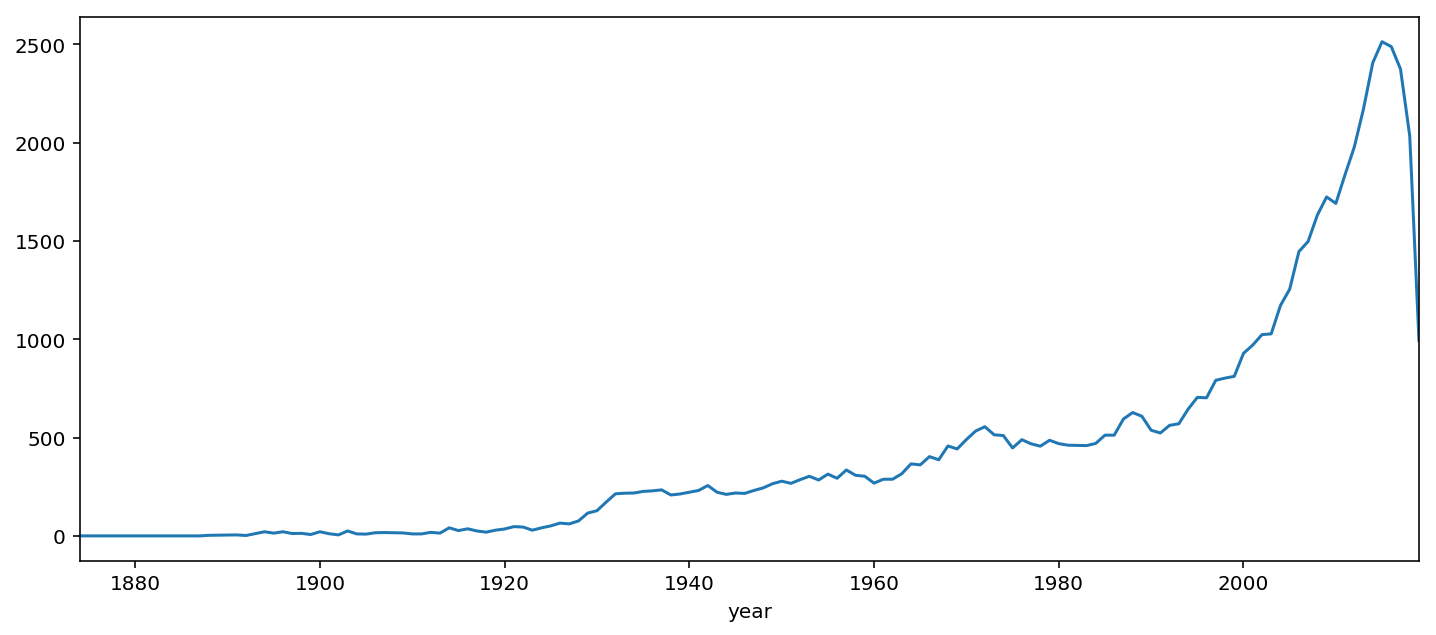

In [22]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year').sort_index()['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [23]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=344, rating=3.0, timestamp=844435558, user_id=5300, next_timestamp=844437310),
 Row(movie_id=333, rating=2.5, timestamp=1485051413, user_id=6357, next_timestamp=1485052289),
 Row(movie_id=2294, rating=3.0, timestamp=965151537, user_id=27760, next_timestamp=1035915802),
 Row(movie_id=8477, rating=4.5, timestamp=1172284762, user_id=29054, next_timestamp=1283022440),
 Row(movie_id=2202, rating=4.0, timestamp=1283022440, user_id=29054, next_timestamp=1318280644),
 Row(movie_id=2389, rating=4.5, timestamp=1318280644, user_id=29054, next_timestamp=1382759416),
 Row(movie_id=98243, rating=2.5, timestamp=1382759416, user_id=29054, next_timestamp=1415154202),
 Row(movie_id=111, rating=4.0, timestamp=862480854, user_id=29894, next_timestamp=862481139),
 Row(movie_id=2706, rating=4.0, timestamp=1240417633, user_id=30970, next_timestamp=1240930687),
 Row(movie_id=1785, rating=1.0, timestamp=976223876, user_id=32855, next_timestamp=991951646)]

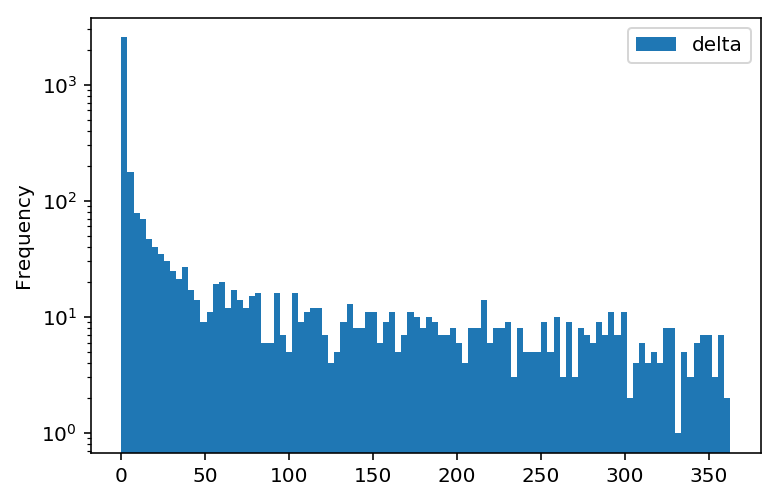

In [24]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [25]:
ratings_df.count()

24968

In [26]:
def get_movie_user_set(ratings_df):
     return ratings_df \
        .groupBy(F.col('movie_id')) \
        .agg(F.collect_set('user_id').alias('user_set'))

get_movie_user_set(ratings_df) \
    .take(10)

[Row(movie_id=471, user_set=[126850, 16494, 75738, 137028, 3937, 140955, 131258, 7836, 121865, 27966, 73242, 19379, 25094, 566, 20943]),
 Row(movie_id=1088, user_set=[80854, 106295, 17482, 144810, 59615, 34339, 117915, 16522, 136706, 116944]),
 Row(movie_id=1238, user_set=[8183, 135739, 162254, 75090]),
 Row(movie_id=1342, user_set=[25881, 99410, 109752, 87394]),
 Row(movie_id=1580, user_set=[137622, 146239, 27841, 120484, 34993, 73300, 28546, 148825, 71238, 15335, 121343, 36431, 110309, 124610, 154098, 118092, 88758, 113607, 117106, 15309, 98638, 53160, 103307, 119379, 128258, 143263, 92680, 9170, 7879, 153905, 142523, 1382, 58150, 124523, 102534, 64736, 28128, 4115, 48759, 3281, 59155, 11491, 90414]),
 Row(movie_id=1591, user_set=[33518, 68428, 31716, 31520]),
 Row(movie_id=1645, user_set=[113634, 146148, 114236, 81657, 34887, 89563, 125947, 128325, 2831, 127142]),
 Row(movie_id=1959, user_set=[80771, 102811, 28264]),
 Row(movie_id=2866, user_set=[35135]),
 Row(movie_id=3175, user_se

In [27]:
def get_similarity_score(user_set_0, user_set):
    user_set_0 = set(user_set_0)
    user_set = set(user_set)
    return len(user_set_0.intersection(user_set)) / len(user_set_0.union(user_set))

get_similarity_score_udf = F.udf(get_similarity_score, FloatType())

In [28]:
def get_most_similar_items(ratings_df, movie_id, N):
    movie_user_set = get_movie_user_set(ratings_df)
    delta = 0.0
    return movie_user_set \
        .filter(F.col('movie_id') == movie_id) \
        .selectExpr('movie_id as movie_id_0', 'user_set as user_set_0') \
        .crossJoin(movie_user_set) \
        .withColumn('sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('sim') > delta) \
        .select('movie_id', 'sim') \
        .sort(F.col('sim').desc()) \
        .take(N)

In [29]:
get_most_similar_items(ratings_df=ratings_df, movie_id=356, N=10)

[Row(movie_id=356, sim=1.0),
 Row(movie_id=95939, sim=0.014285714365541935),
 Row(movie_id=4491, sim=0.014285714365541935),
 Row(movie_id=126, sim=0.014084506779909134),
 Row(movie_id=5292, sim=0.014084506779909134),
 Row(movie_id=4040, sim=0.013888888992369175),
 Row(movie_id=2052, sim=0.013888888992369175),
 Row(movie_id=3461, sim=0.013888888992369175),
 Row(movie_id=3200, sim=0.013888888992369175),
 Row(movie_id=71745, sim=0.013698630034923553)]

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим числом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [30]:
def get_popular_items(ratings_df, user_id, N):
    del user_id  # Not used
    
    return ratings_df \
        .groupby('movie_id') \
        .count() \
        .sort(F.col('count').desc()) \
        .take(N)

In [31]:
get_popular_items(ratings_df, user_id=65346, N=10)

[Row(movie_id=2571, count=85),
 Row(movie_id=318, count=85),
 Row(movie_id=356, count=70),
 Row(movie_id=593, count=70),
 Row(movie_id=527, count=69),
 Row(movie_id=589, count=69),
 Row(movie_id=1, count=65),
 Row(movie_id=47, count=63),
 Row(movie_id=1270, count=62),
 Row(movie_id=260, count=62)]

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [32]:
import math

def get_cosine_similarity(movie_set_0, movie_set):
    dot_product = len(set(movie_set_0).intersection(set(movie_set)))
    norm_0 = math.sqrt(len(movie_set_0))
    norm = math.sqrt(len(movie_set))
    return dot_product / (norm_0 * norm)

cosine_similarity_udf = F.udf(get_cosine_similarity, FloatType())

def get_user_movie_set(ratings_df):
    return ratings_df \
        .groupBy(F.col('user_id')) \
        .agg(F.collect_set('movie_id').alias('movie_set'))

def get_similar_users(ratings_df, user_id):
    user_movie_set = get_user_movie_set(ratings_df)
    alpha = 0.0
    return user_movie_set \
        .filter(F.col('user_id') == user_id) \
        .selectExpr('user_id as user_id_0', 'movie_set as movie_set_0') \
        .crossJoin(user_movie_set) \
        .withColumn('sim', cosine_similarity_udf('movie_set_0', 'movie_set')) \
        .filter(F.col('sim') > alpha) \
        .groupby('user_id_0') \
        .agg(F.collect_set('user_id').alias('user_set')) \
        .selectExpr('user_id_0 as user_id', 'user_set as user_set')

In [33]:
get_similar_users(ratings_df, user_id=65346) \
    .take(10)

[Row(user_id=65346, user_set=[50816, 11072, 122966, 32922, 15108, 119475, 156577, 130502, 129871, 57976, 106700, 41135, 125967, 65346, 157539, 22627, 97049, 1619, 9168, 60448])]

In [34]:
def get_user_based_collab(ratings_df, user_id, N):
    movie_user_set = get_movie_user_set(ratings_df)
    return get_similar_users(ratings_df, user_id) \
        .selectExpr('user_set as user_set_0') \
        .crossJoin(movie_user_set) \
        .withColumn('sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('sim') > 0.0) \
        .sort(F.col('sim').desc()) \
        .select('movie_id', 'sim') \
        .take(N)

In [35]:
get_user_based_collab(ratings_df=ratings_df, user_id=65346, N=10)

[Row(movie_id=2640, sim=0.6000000238418579),
 Row(movie_id=1373, sim=0.44999998807907104),
 Row(movie_id=58191, sim=0.05000000074505806),
 Row(movie_id=8860, sim=0.0476190485060215),
 Row(movie_id=6296, sim=0.04545454680919647),
 Row(movie_id=30825, sim=0.03448275849223137),
 Row(movie_id=2144, sim=0.032258063554763794),
 Row(movie_id=11, sim=0.032258063554763794),
 Row(movie_id=1061, sim=0.029411764815449715),
 Row(movie_id=1214, sim=0.016949152573943138)]

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [36]:
def get_item_knn(ratings_df, user_id, N):
    movie_user_set = get_movie_user_set(ratings_df)

    user_movies = ratings_df \
        .filter(F.col('user_id') == user_id)
    
    user_movies_user_set = get_similar_users(ratings_df, user_id) \
        .join(user_movies, 'user_id') \
        .selectExpr('movie_id as movie_id', 'user_set as user_user_set')
    
    delta = 0.0
    nearest_movies_user_sets = user_movies_user_set \
        .join(movie_user_set, ['movie_id']) \
        .selectExpr('movie_id as movie_id_0', 'user_set as user_set_0', 'user_user_set as user_user_set') \
        .crossJoin(movie_user_set) \
        .withColumn('movie_sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('movie_sim') > delta) \
        .selectExpr('movie_id as movie_id', 'user_set as movie_user_set', 'user_user_set as user_user_set')
    
    return nearest_movies_user_sets \
        .withColumn('sim', get_similarity_score_udf('movie_user_set', 'user_user_set')) \
        .filter(F.col('sim') > 0.0) \
        .sort(F.col('sim').desc()) \
        .select('movie_id', 'sim') \
        .distinct() \
        .take(N)

In [37]:
get_item_knn(ratings_df=ratings_df, user_id=65346, N=10)

[Row(movie_id=2640, sim=0.6000000238418579),
 Row(movie_id=1373, sim=0.44999998807907104),
 Row(movie_id=58191, sim=0.05000000074505806),
 Row(movie_id=8860, sim=0.0476190485060215),
 Row(movie_id=6296, sim=0.04545454680919647),
 Row(movie_id=30825, sim=0.03448275849223137),
 Row(movie_id=2144, sim=0.032258063554763794),
 Row(movie_id=11, sim=0.032258063554763794),
 Row(movie_id=1061, sim=0.029411764815449715),
 Row(movie_id=1214, sim=0.016949152573943138)]

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [38]:
user_window = Window.orderBy('timestamp').partitionBy('user_id')

tiled_ratings_df = ratings_df \
    .withColumn('tile', F.ntile(10).over(user_window)) \

tiled_ratings_df \
    .take(10)

[Row(movie_id=1245, rating=4.5, timestamp=1429642474, user_id=1342, tile=1),
 Row(movie_id=2080, rating=3.5, timestamp=1078331018, user_id=2142, tile=1),
 Row(movie_id=8983, rating=3.5, timestamp=1238724922, user_id=4818, tile=1),
 Row(movie_id=3949, rating=4.0, timestamp=1218578041, user_id=4935, tile=1),
 Row(movie_id=344, rating=3.0, timestamp=844435558, user_id=5300, tile=1),
 Row(movie_id=359, rating=3.0, timestamp=844437310, user_id=5300, tile=2),
 Row(movie_id=333, rating=2.5, timestamp=1485051413, user_id=6357, tile=1),
 Row(movie_id=1934, rating=5.0, timestamp=1485052289, user_id=6357, tile=2),
 Row(movie_id=85438, rating=4.0, timestamp=1380215170, user_id=7240, tile=1),
 Row(movie_id=3469, rating=5.0, timestamp=962740124, user_id=7253, tile=1)]

In [39]:
train_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') <= 7) \
    .drop('tile')

print(train_ratings_df.count())

train_ratings_df.take(10)

24940


[Row(movie_id=1245, rating=4.5, timestamp=1429642474, user_id=1342),
 Row(movie_id=2080, rating=3.5, timestamp=1078331018, user_id=2142),
 Row(movie_id=8983, rating=3.5, timestamp=1238724922, user_id=4818),
 Row(movie_id=3949, rating=4.0, timestamp=1218578041, user_id=4935),
 Row(movie_id=344, rating=3.0, timestamp=844435558, user_id=5300),
 Row(movie_id=359, rating=3.0, timestamp=844437310, user_id=5300),
 Row(movie_id=333, rating=2.5, timestamp=1485051413, user_id=6357),
 Row(movie_id=1934, rating=5.0, timestamp=1485052289, user_id=6357),
 Row(movie_id=85438, rating=4.0, timestamp=1380215170, user_id=7240),
 Row(movie_id=3469, rating=5.0, timestamp=962740124, user_id=7253)]

In [40]:
dev_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') == 8) \
    .drop('tile')

print(dev_ratings_df.count())

dev_ratings_df.take(10)

13


[Row(movie_id=137471, rating=3.5, timestamp=1554354214, user_id=17783),
 Row(movie_id=171805, rating=1.0, timestamp=1535853970, user_id=49403),
 Row(movie_id=170697, rating=3.5, timestamp=1541004163, user_id=37438),
 Row(movie_id=7077, rating=3.5, timestamp=1229475429, user_id=80974),
 Row(movie_id=3246, rating=4.0, timestamp=1486934245, user_id=115102),
 Row(movie_id=93838, rating=3.0, timestamp=1353740225, user_id=109731),
 Row(movie_id=181671, rating=4.0, timestamp=1535602372, user_id=72315),
 Row(movie_id=194204, rating=1.5, timestamp=1551180061, user_id=72315),
 Row(movie_id=186001, rating=2.0, timestamp=1551527829, user_id=72315),
 Row(movie_id=5103, rating=3.0, timestamp=1440188214, user_id=137293)]

In [41]:
test_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') == 9) \
    .drop('tile')

print(test_ratings_df.count())

test_ratings_df.take(10)

8


[Row(movie_id=167986, rating=0.5, timestamp=1544921053, user_id=49403),
 Row(movie_id=201586, rating=2.5, timestamp=1571028530, user_id=37438),
 Row(movie_id=48315, rating=3.0, timestamp=1245198755, user_id=80974),
 Row(movie_id=26314, rating=1.5, timestamp=1400048816, user_id=109731),
 Row(movie_id=181071, rating=3.5, timestamp=1566672262, user_id=72315),
 Row(movie_id=68664, rating=2.5, timestamp=1566672695, user_id=72315),
 Row(movie_id=205683, rating=3.5, timestamp=1568758743, user_id=72315),
 Row(movie_id=181159, rating=3.5, timestamp=1520220970, user_id=137293)]

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [42]:
from pyspark.mllib.evaluation import RankingMetrics

test_user_labels = test_ratings_df \
    .groupby('user_id') \
    .agg(F.collect_set('movie_id').alias('labels')) \
    .rdd \
    .collect()

def evaluate(get_predictions_fn):

    predictions_labels = []
    for row in test_user_labels[:10]:
        predictions = get_predictions_fn(ratings_df, row.user_id, N=10)
        predictions = list(map(lambda row: row.movie_id, predictions))
        labels = row.labels
        predictions_labels.append((predictions, labels))
    
    pre_lab_paral = sc.parallelize(predictions_labels)
    ranking_metrics = RankingMetrics(pre_lab_paral)

    for N in [1, 5, 10]:
        print("precision @", N, ranking_metrics.precisionAt(N))
        print("NDCG @", N, ranking_metrics.ndcgAt(N))
    print("map", ranking_metrics.meanAveragePrecision)

In [43]:
def get_true_labels(ratings_df, user_id, N):
    del ratings_df  # Not used
    return test_ratings_df \
        .filter(F.col('user_id') == user_id) \
        .take(N)

evaluate(get_true_labels)

precision @ 1 1.0
NDCG @ 1 1.0
precision @ 5 0.26666666666666666
NDCG @ 5 1.0
precision @ 10 0.13333333333333333
NDCG @ 10 1.0
map 1.0


## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [44]:
evaluate(get_popular_items)

precision @ 1 0.0
NDCG @ 1 0.0
precision @ 5 0.0
NDCG @ 5 0.0
precision @ 10 0.0
NDCG @ 10 0.0
map 0.0


In [45]:
evaluate(get_user_based_collab)

precision @ 1 0.0
NDCG @ 1 0.0
precision @ 5 0.0
NDCG @ 5 0.0
precision @ 10 0.06666666666666667
NDCG @ 10 0.19295516184525652
map 0.07936507936507936


In [46]:
evaluate(get_item_knn)

precision @ 1 0.0
NDCG @ 1 0.0
precision @ 5 0.0
NDCG @ 5 0.0
precision @ 10 0.06666666666666667
NDCG @ 10 0.18098399865331374
map 0.06825396825396825
